In [48]:
# If you don't already have it...
#import sys
#!{sys.executable} -m pip install nflows
#!{sys.executable} -m pip install uproot

### Extracting and inverting transformations

Up until now, I've managed to train a flow to go from a Gaussian to the LHCb simulated IP distribution of Z->mu mu decays. 

It'll work just as well from a Gaussian to the data shape.

If this were to be used in an analysis, we'd need to tie these together into 1 2-step transformation.

Then we need to be able to extract the transformation as a 1-to-1 function that we can apply, rather than a sampling.

First of all, let's use a v.simple test transform of e.g. 1D Gaussian -> Gaussian to work out how to string 2 transforms together, and then extract a transformation function. We could then apply the transformation function on another sample to check that it works fine.  

In [59]:
from nflows import transforms, distributions, flows
import torch
import matplotlib.pyplot as plt

In [51]:
def make_basic_flow(hidden_features=4):
    transform = transforms.CompositeTransform([
        transforms.MaskedAffineAutoregressiveTransform(features=2, hidden_features=hidden_features),
        transforms.RandomPermutation(features=2)
    ])
    base_distribution = distributions.StandardNormal(shape=[2])
    flow = flows.Flow(transform=transform, distribution=base_distribution)
    return flow

In [55]:
N_SAMPLES = 1000

In [49]:
def train_flow(flow, target):
    optimizer = torch.optim.Adam(flow.parameters())
    n_iter = 5000
    for i in range(n_iter):
        #flow.train() # Put it in training mode.

        # TODO Need to understand why we zero_grad() before calculating the loss.
        # TODO also need to understand the loss
        # TODO why no forward pass?
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=target).mean()
        loss.backward()
        optimizer.step()

        ### Testing the thing
        # flow.eval() # Put it in evaluation mode.
        with torch.inference_mode():
            if i % 1000 == 0:
                print(f"Loss at iteration {i}: {loss}")
                xline = torch.linspace(-10, 10, 100)
                yline = torch.linspace(-10, 10, 100)
                xgrid, ygrid = torch.meshgrid(xline, yline)
                xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

                zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

                plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
                plt.title('iteration {}'.format(i + 1))
                plt.show()

In [50]:
# Generate some data to flow to as we did in the first tutorial
torch.manual_seed(42)
target = 2.0 * torch.randn(N_SAMPLES, 2) + 5

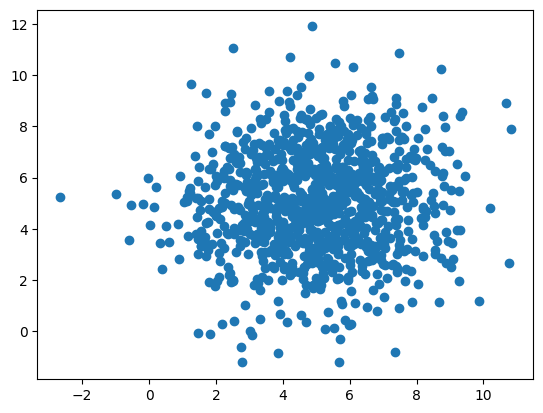

In [53]:
plt.figure()
plt.scatter(target[:, 0], target[:, 1])
plt.show()

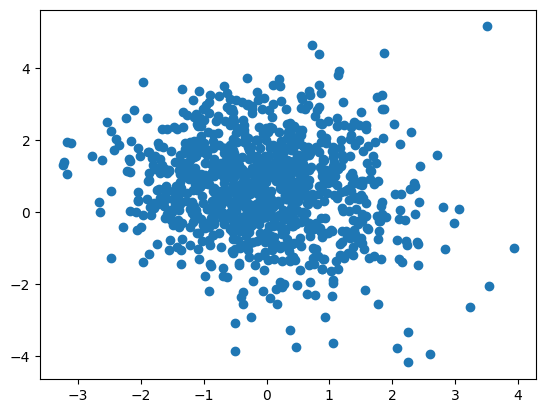

In [52]:
# Plot the base distribution of the flow i.e. the initial state
flow = make_basic_flow()
with torch.inference_mode():
    pretrain_samples = flow.sample(N_SAMPLES)
    plt.figure()
    plt.scatter(pretrain_samples[:, 0], pretrain_samples[:, 1])
    plt.show()

Bit weird, but OK. Looks roughly like a 2D Gaussian.

Now let's do the flow.

Loss at iteration 0: 16.875436782836914


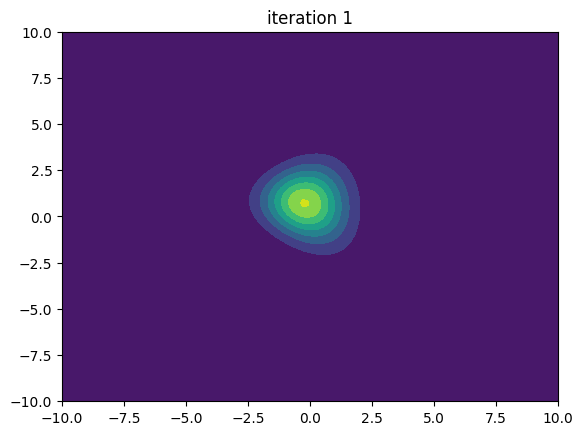

Loss at iteration 1000: 5.889936447143555


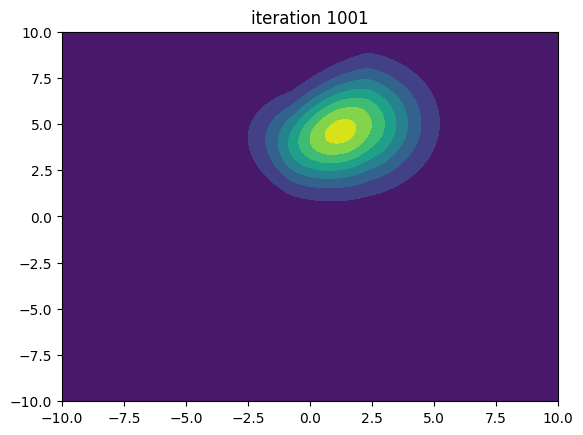

Loss at iteration 2000: 4.500308990478516


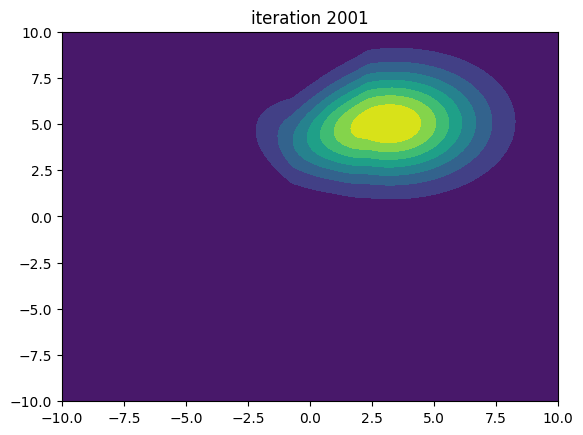

Loss at iteration 3000: 4.3172478675842285


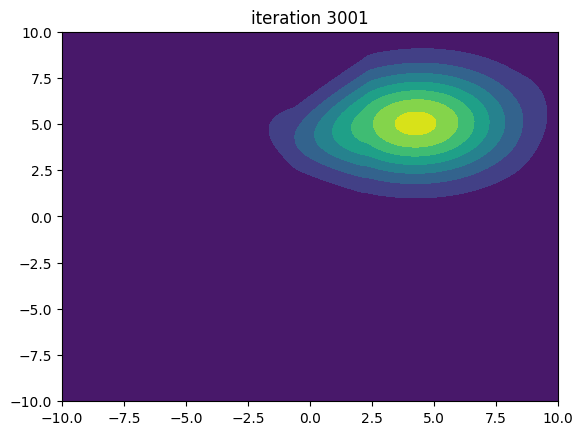

Loss at iteration 4000: 4.271146297454834


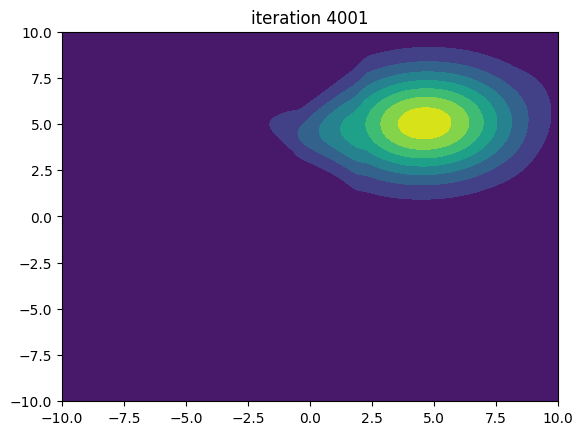

In [54]:
train_flow(flow, target)

It has pretty much worked. Strange tail, but the quality of the flow is not so important for now, what I want to test if I can extract the transformation.

So now let's draw another sample of a 2D standard gaussian, and apply the transformation with the `forward` method of the flow.

<class 'torch.Tensor'>


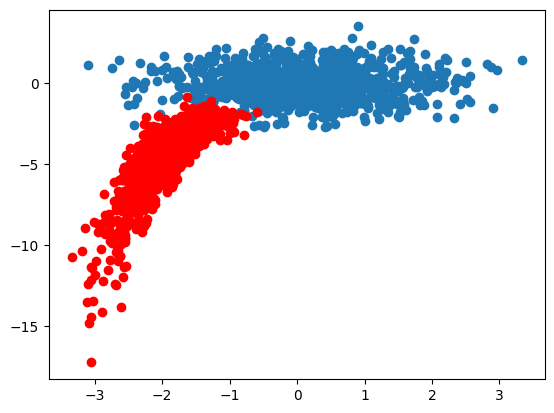

In [58]:
# Draw another sample
indep_sample = torch.randn(N_SAMPLES, 2)#.reshape(-1, 1)

# Will need to make it a tensor with a dummy batch dimension
print(type(indep_sample))
# flow.forward isnt allowed
# transform_to_noise doesn't sound like what I want but try...
transformed = flow.transform_to_noise(indep_sample)

with torch.inference_mode():
    plt.figure()
    plt.scatter(indep_sample[:, 0], indep_sample[:, 1])
    plt.scatter(transformed[:, 0], transformed[:, 1], color='red')
    plt.show()

Well, that's certainly not what we are after.

A ``nflows.Transform`` object has a `forward` and `inverse` method. Why doesn't the flow, or how do I access the transform of the flow?

In [56]:
print(transformed)

tensor([[ -5.7990,  -2.4340],
        [ -6.3449,  -2.0840],
        [-17.7120,  -2.8689],
        ...,
        [ -5.6643,  -2.3505],
        [ -2.5722,  -1.9608],
        [ -2.6943,  -1.4598]], grad_fn=<IndexSelectBackward0>)


Could it be that the `transform_to_noise` function should be applied to the target, and it will get it back to the noise, i.e. the inverse transformation? It looks like that could be right.

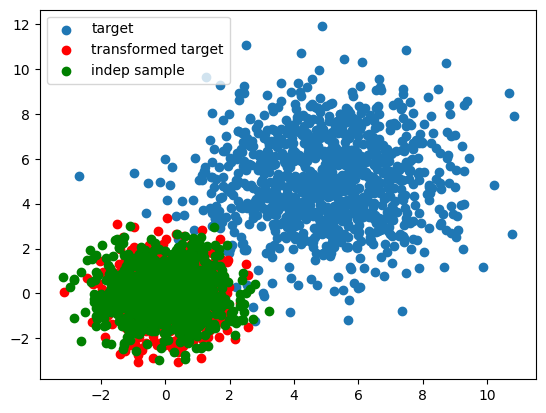

In [57]:
transformed_target = flow.transform_to_noise(target)
with torch.inference_mode():
    plt.figure()
    plt.scatter(target[:, 0], target[:, 1], label='target')
    plt.scatter(transformed_target[:, 0], transformed_target[:, 1], color='red', label='transformed target')
    plt.scatter(indep_sample[:, 0], indep_sample[:, 1], color='green', label='indep sample')
    plt.legend()
    plt.show()

Indeed, that is what it does. So we have found the inverse transformation, and we can apply it a given dataset. That's one of our goals :tick:

So now, in the end we are going to do LHCb simulated IP -> Gaussian -> LHCb data IP as our total transformation. After training a Gaussian -> simulated IP flow, it's clear that we could employ `transform_to_noise` to go backwards. This is indeed a 1-to-1 mapping of the simulated shape to a Gaussian. Now we need to know how to (without sampling) employ a forward transformation of a flow.

Reading the doc string of a `Flow` object, and looking also at the `transform_to_noise` function, I just need to put in an `inverse` somewhere.

Reading through the issue list on GitHub again, I came across mention of `transforms.InverseTransform`, which you construct with another transform. So can I construct it with a pre-trained transform? That would mean I need to pull the `transform` out of my flow.

In [60]:
inverse = transforms.InverseTransform(flow._transform)

(tensor([[2.7462, 4.1216],
        [6.6699, 5.2077],
        [6.2495, 5.2634],
        ...,
        [3.1725, 5.0872],
        [4.6768, 3.8483],
        [3.8250, 5.7403]], grad_fn=<DivBackward0>), tensor([1.5668, 1.5655, 1.5656, 1.5666, 1.5659, 1.5656, 1.5662, 1.5944, 1.5661,
        1.5655, 1.5657, 1.5651, 1.5663, 1.5665, 1.5664, 1.5656, 1.5660, 1.5658,
        1.5668, 1.5651, 1.0513, 1.5662, 1.5662, 1.5777, 1.4171, 1.5657, 1.5651,
        1.5667, 1.5662, 1.5660, 1.5664, 1.1943, 1.5657, 1.1244, 1.5657, 1.5656,
        1.5658, 1.5666, 1.5661, 1.5653, 1.5667, 1.5655, 1.5654, 1.5661, 1.5655,
        1.3856, 1.5660, 1.5657, 1.5658, 1.5650, 1.5660, 1.5658, 1.5668, 1.5663,
        1.5680, 1.5666, 1.5926, 1.5659, 1.5660, 1.5651, 1.5658, 1.5652, 1.5664,
        1.5668, 1.5662, 1.5658, 1.5668, 1.6017, 1.5664, 1.5668, 1.5656, 1.5663,
        1.5650, 1.5664, 1.5653, 1.5073, 1.5668, 1.5656, 1.5657, 1.5664, 1.1126,
        1.5660, 1.6595, 1.5664, 1.5660, 1.5669, 1.5668, 1.5659, 1.5657, 1.5662,
    

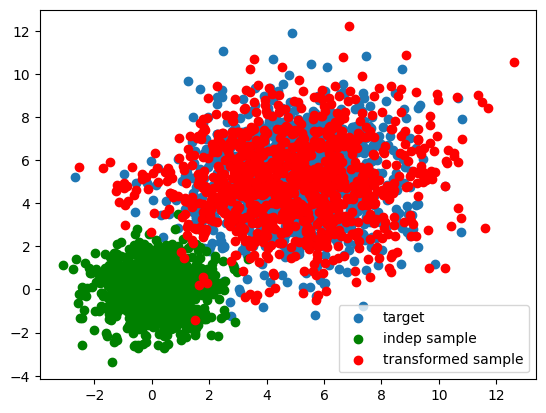

In [61]:
inverse_data = inverse.forward(indep_sample)
print(inverse_data)
print(type(inverse_data))
print(type(inverse_data[0]))
print(inverse_data[0].shape)
with torch.inference_mode():
    plt.figure()
    plt.scatter(target[:, 0], target[:, 1], label='target')
    plt.scatter(indep_sample[:, 0], indep_sample[:, 1], color='green', label='indep sample')
    plt.scatter(inverse_data[0][:, 0], inverse_data[0][:, 1], color='red', label='transformed sample')
    plt.legend()
    plt.show()

Et voila again! So now I seem to have found a hacky way to extract the inverse transform. 

It was a bit of a hack. Looking back at what I did, it was in total `InverseTransform(flow._transform).forward()`. Calling a ~private member function is a hack, but if had the transform around (rather than just letting it go out of scope in the `make_basic_flow` function), then I could just do `InverseTransform(transform).forward()`. Still a bit weird. 

Could I have just done `transform.inverse()`?

Let's try and instance the flow in a different way then.

In [62]:
def make_basic_flow_return_transform(hidden_features=4):
    transform = transforms.CompositeTransform([
        transforms.MaskedAffineAutoregressiveTransform(features=2, hidden_features=hidden_features),
        transforms.RandomPermutation(features=2)
    ])
    base_distribution = distributions.StandardNormal(shape=[2])
    flow = flows.Flow(transform=transform, distribution=base_distribution)
    return flow, transform

Loss at iteration 0: 15.600141525268555


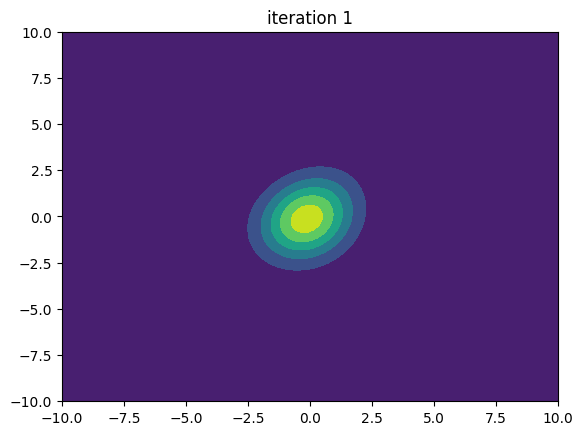

Loss at iteration 1000: 5.4490966796875


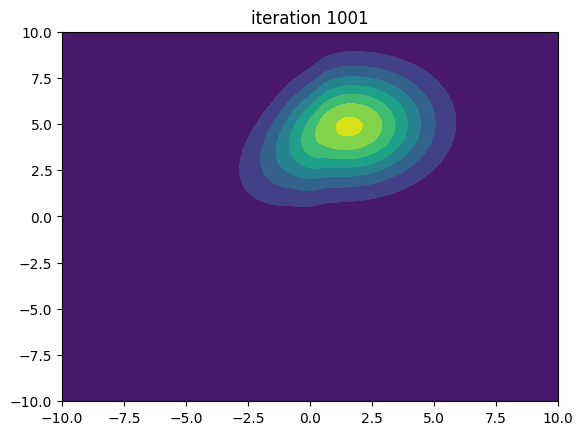

Loss at iteration 2000: 4.470008373260498


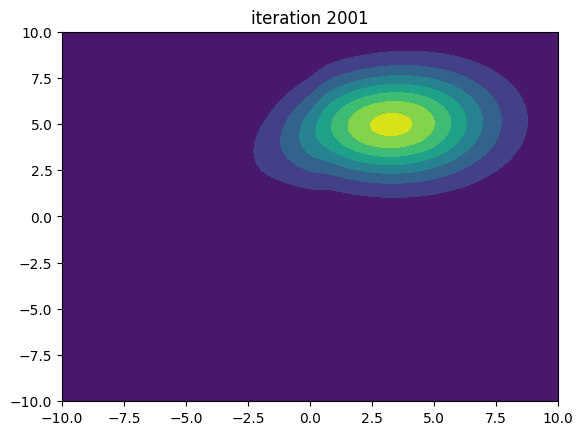

Loss at iteration 3000: 4.341302394866943


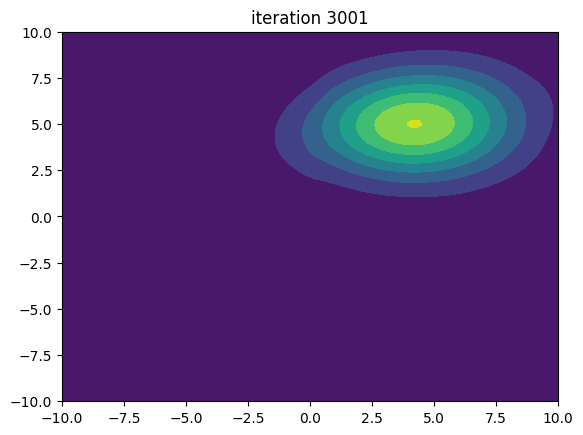

Loss at iteration 4000: 4.2841410636901855


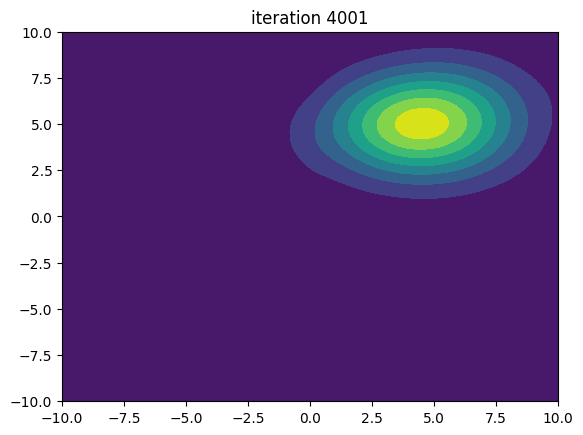

In [63]:
new_flow, new_transform = make_basic_flow_return_transform()
train_flow(new_flow, target)

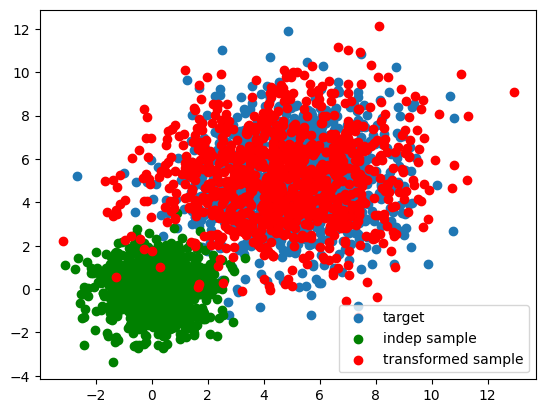

In [64]:
inverse_data = new_transform.inverse(indep_sample)
with torch.inference_mode():
    plt.figure()
    plt.scatter(target[:, 0], target[:, 1], label='target')
    plt.scatter(indep_sample[:, 0], indep_sample[:, 1], color='green', label='indep sample')
    plt.scatter(inverse_data[0][:, 0], inverse_data[0][:, 1], color='red', label='transformed sample')
    plt.legend()
    plt.show()

Yep, that worked perfectly, and showed that we don't need the `Flow.transform_to_noise` function, we can just get at it via the `Transform.forward` function. It might even be that the `operator()` is overloaded for this, since it does inherit from a `nn.Module`.

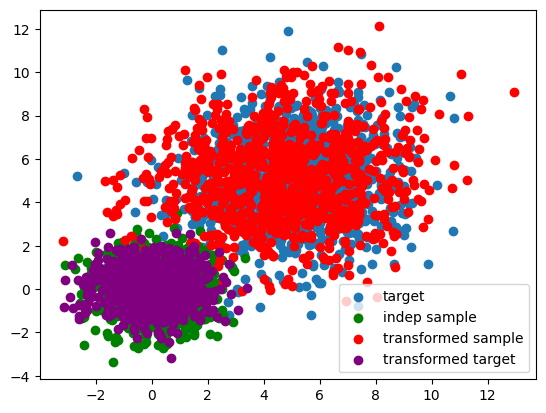

In [65]:
transformed_target = new_transform(target)
with torch.inference_mode():
    plt.figure()
    plt.scatter(target[:, 0], target[:, 1], label='target')
    plt.scatter(indep_sample[:, 0], indep_sample[:, 1], color='green', label='indep sample')
    plt.scatter(inverse_data[0][:, 0], inverse_data[0][:, 1], color='red', label='transformed sample')
    plt.scatter(transformed_target[0][:, 0], transformed_target[0][:, 1], color='purple', label='transformed target')
    plt.legend()
    plt.show()

Yep, indeed, `operator()` is overloaded, we see above that we can go from target to noise via `operator()`. This is all in line with the naming of "normalising flows" - they are **normalising** in the sense that they turn data into a normal distribution. This is commented on in the [issue that I read to point me in the right direction with all this](https://github.com/bayesiains/nflows/issues/32).

### Stringing together transformations

I should now be able to make use of `CompositeTransform` to put two transforms together. I can try to demonstrate that by using the transformation I have trained above in combination with the `InverseTransform` of it. The combination should therefore get me back my training sample.

Let's try to stick to the naming convention of `nflows`: a forward transformation is data -> noise (normalising). The data in this case is a shifted and scaled 2D Gaussian.

So to go from data -> data (data is our starting point) we do a forward transformation on the target, then inverse one.

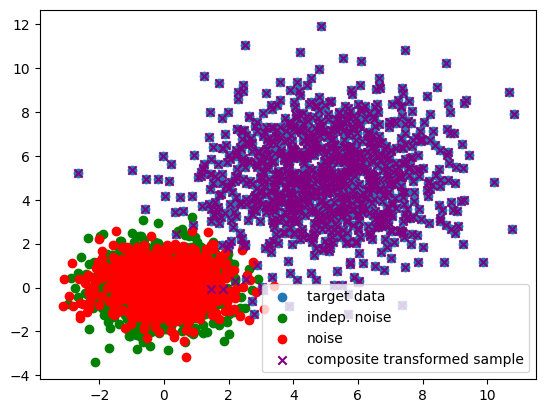

In [66]:
inverse_transform = transforms.InverseTransform(new_transform)

identity_composite_transform = transforms.CompositeTransform(
    [new_transform, inverse_transform]
)

indep_noise = torch.randn(N_SAMPLES, 2)
noise = new_transform(target)
composite_sample = identity_composite_transform(target)
with torch.inference_mode():
    plt.figure()
    plt.scatter(target[:, 0], target[:, 1], label='target data', marker='o')
    plt.scatter(indep_noise[:, 0], indep_noise[:, 1], color='green', label='indep. noise')
    plt.scatter(noise[0][:, 0], noise[0][:, 1], color='red', label='noise')
    plt.scatter(composite_sample[0][:, 0], composite_sample[0][:, 1], color='purple', label='composite transformed sample', marker='x')
    plt.legend()
    plt.show()

Yep, done it. We se the purple crosses lie **exactly** over the target data, so we have successfully constructed an identity from two transforms.

### Summary

Given a trained `Flow` and `Transform`, where the `Transform` is "normalising" (i.e. it goes from data -> a normal distribution) we can:
* Get the inverse (i.e. noise -> data) with `transforms.InverseTransform(transform)`,
* Put two transforms together simply with `CompositeTransform([transform1, transform2])`.

Thus it should be very straightforward to train two separates transforms:
1) `transform1`: 1D Gaussian -> LHCb IP in simulation,
2) `transform2`: 1D Gaussian -> LHCb IP in data.

and the transformation we really want (LHCb IP in simulation -> LHCb IP in data) is then simply `CompositeTransform([transform1, InverseTransform(transform2)])` 